# CAP 6618 - Machine Learning for Computer Vision

Christian Garbin
Spring 2019

# Programming Project 5
See guidelines on Canvas for details.

Source for the code is Géron's chapter 13, exercise solutions: https://github.com/ageron/handson-ml/blob/master/13_convolutional_neural_networks.ipynb. The main changes are to make the code generic, to support other datasets.

**IMPORTANT**: This notebook requires Python 3.x.

## Step 1: Setup

### Step 1.1: Environment setup

In [1]:
# Common imports
import numpy as np
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

### Step 1.2: Experiment setup

This object holds data we need to run the experiment.

There is only one, global object, used in several places (not ideal, but in this context it's better than polluting the parameter list of every function or having it spread across several global variables).

In [4]:
class ExperimentData:
    '''URL for the dataset file. Expected to be a zipped file.'''
    dataset_url: str
    '''Destination folder for the dataset in the local computer.'''
    dataset_folder: str
    '''Destination folder for extracted pictures (subfolder of the above,
    usually a folder inside the zipped file).'''
    dataset_subfolder: str
    '''Class names, extracted from directory names.'''
    class_names: str
        
    '''URL for the pretrained model. Expected to be a zipped file.'''
    model_url: str
    '''Destination folder for the model.'''
    model_folder: str
    '''File name for the model.'''
    model_file_name: str
    '''The last layer we will use from the pretained model. Usually the
    layer just before the fully connected layers.'''
    model_last_layer: str

    '''Picture dimensions used in the pretrained model.'''
    width: int
    height: int
    channels: int

In [5]:
experiment = ExperimentData()

experiment.dataset_url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
experiment.dataset_folder = os.path.join('datasets', 'flowers')
experiment.dataset_subfolder = os.path.join(experiment.dataset_folder, 'flower_photos')

experiment.model_url = 'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz'
experiment.model_folder = os.path.join('datasets', 'inception')
experiment.model_file_name = os.path.join(experiment.model_folder, 'inception_v3.ckpt')
experiment.model_last_layer = 'PreLogits'

# Inception's image size and channels (RGB)
experiment.width = 299
experiment.height = 299
experiment.channels = 3

## Step 2: Transfer Learning for image classification using TensorFlow and Inception v3

In this step we will use a pre-trained Inception v3 model, freeze all layers up to the bottleneck layer (i.e., the last layer before the output layer), and replace the output layer with the appropriate number of outputs for a new classification task: the 5-class flowers dataset (https://www.tensorflow.org/tutorials/image_retraining).

### 2.1: Fetching the data

In [6]:
import sys
import tarfile
from six.moves import urllib

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_file(url, path):
    # Already downloaded - use the cached contents.
    # Note that it tests for the presence of the destination folder, not
    # the actual contents. Delete the entire folder to force a new download.
    if os.path.exists(path):
        print('Using cached contents')
        return
    
    # The file name from the URL - the last piece
    file_name = url.split('/')[-1]
    
    # Download to local file, extract contents
    print('Downloading {}'.format(file_name))
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, file_name)
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    tgz = tarfile.open(tgz_path)
    tgz.extractall(path=path)
    tgz.close()
    os.remove(tgz_path)

In [7]:
fetch_file(experiment.dataset_url, experiment.dataset_folder)

Using cached contents


Each subdirectory of the directory contains all the pictures of a given class. Let's get the list of classes:

In [8]:
experiment.class_names = sorted([dirname for dirname in os.listdir(experiment.dataset_subfolder)
                          if os.path.isdir(os.path.join(experiment.dataset_subfolder, dirname))])
experiment.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Let's get the list of all the image file paths for each class, sort the image paths just to make this notebook behave consistently across multiple runs, and take a peek at a few samples per class.

In [9]:
from collections import defaultdict

image_paths = defaultdict(list)

for class_name in experiment.class_names:
    image_dir = os.path.join(experiment.dataset_subfolder, class_name)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[class_name].append(os.path.join(image_dir, filepath))
            
for paths in image_paths.values():
    paths.sort() 

Class: daisy


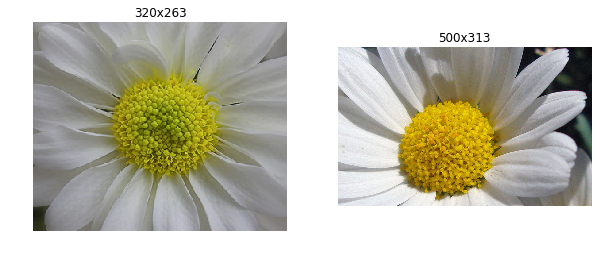

Class: dandelion


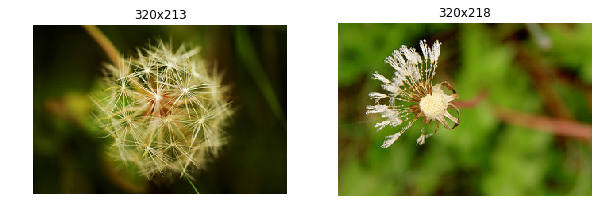

Class: roses


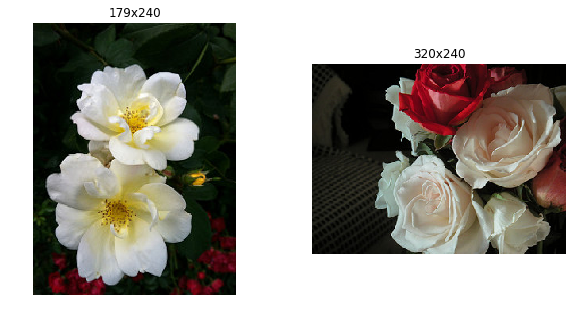

Class: sunflowers


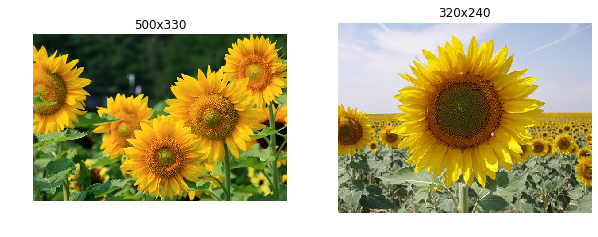

Class: tulips


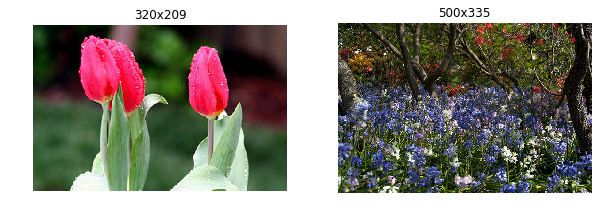

In [10]:
import matplotlib.image as mpimg

n_examples_per_class = 2

for class_name in experiment.class_names:
    print("Class:", class_name)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[class_name][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :experiment.channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

### 2.2: Image preprocessing + data augmentation

Sources on why we need to resize the images:

- [To match what the original network was trained on](https://www.quora.com/Is-dimensionality-of-input-images-fixed-when-using-pre-trained-CNNs-in-Keras-for-transfer-learning), ensuring that the weights and other parameters are still applicable.
- [Mathworks doc that says we have to do it](https://www.mathworks.com/help/deeplearning/ug/preprocess-images-for-deep-learning.html), although doesn't explain the reason.
- [CNTK's tutorial](https://cntk.ai/pythondocs/CNTK_301_Image_Recognition_with_Deep_Transfer_Learning.html) also says we have to resize, without explaining why.

In [11]:
from scipy.misc import imresize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    image = imresize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as
    # 32-bit floats ranging from 0.0 to 1.0 (for now):
    return image.astype(np.float32) / 255


Let's check out the result on one (random) image.

The original image.

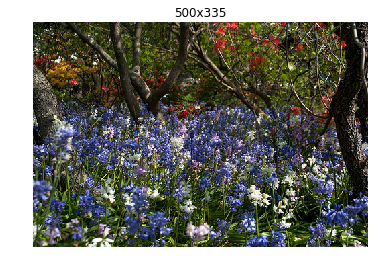

In [12]:
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

After preparing it.

/Users/cgarbin/fau/cap6618/env/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


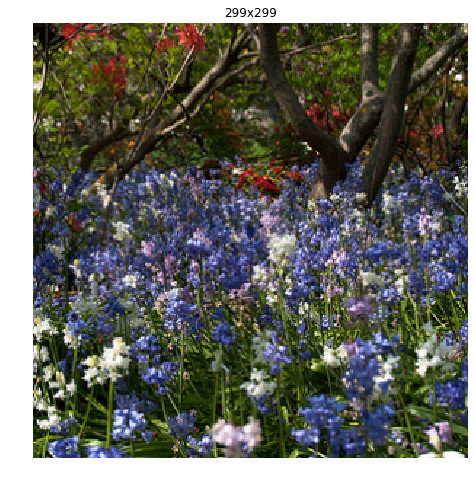

In [13]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Show the random cropping and zooming of images.

/Users/cgarbin/fau/cap6618/env/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


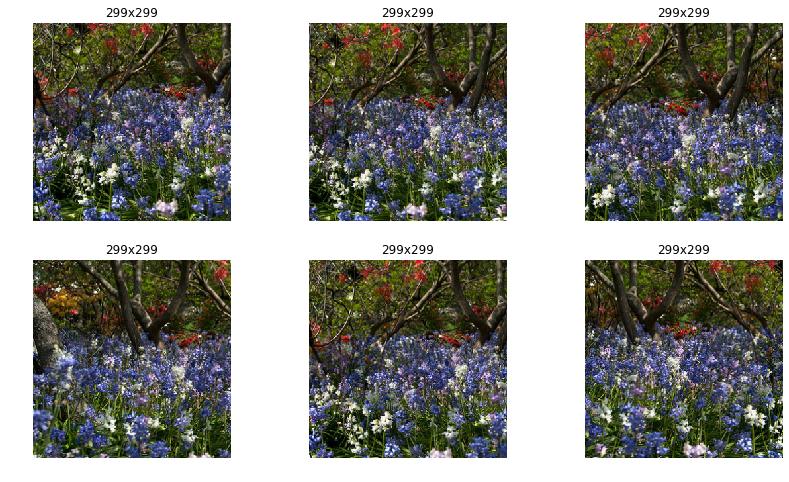

In [14]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

### 2.3: Load pre-trained Inception v3

In the future: we should download from TF Hub https://www.tensorflow.org/hub/.

In [15]:
fetch_file(experiment.model_url, experiment.model_folder)

Using cached contents


From Géron: Create the Inception v3 model by calling the inception_v3() function, as shown below. This must be done within an argument scope created by the inception_v3_arg_scope() function. Also, you must set `is_training=False` and `num_classes=1001` [...]

TODO: we are not setting `is_training` to False. Need to investigate how that works in this context.

In [18]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32,
                   shape=[None, experiment.height, experiment.width, experiment.channels],
                   name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

List of layers in the model.

We need to find the layer that gives the predictions, so we can use the model up to that layer and plug in our prediction layer.

In this case the model is named nicely enough `PreLogits`, right before the `Predictions` layer, the one we will replace.

In [19]:
end_points

{'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=float32>,
 'Mixed_5b': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5b/concat:0' shape=(?, 35, 35, 256) dtype=float32>,
 'Mixed_5c': <tf.Tensor 'InceptionV3/InceptionV3/Mixed_5c/concat:0' shape=(?,

In [20]:
end_points[experiment.model_last_layer]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

We can drop the 2nd and 3rd dimensions using the `tf.squeeze()` function:

TODO: Understand why do we need to do this. Because we don't have a flatten layer after it?

In [21]:
reused_layer = tf.squeeze(end_points[experiment.model_last_layer], axis=[1, 2])

Then we can add the final fully connected layer on top of this layer:

(This is our new, customized prediction layer)

In [22]:
n_outputs = len(experiment.class_names)

LOGIT_LAYER_NAME = 'new_logits'

with tf.name_scope("new_output_layer"):
    new_logits = tf.layers.dense(reused_layer, n_outputs, name=LOGIT_LAYER_NAME)
    Y_proba = tf.nn.softmax(new_logits, name="Y_proba")

Finally, we need to add the usual bits and pieces:

* the placeholder for the targets (`y`),
* the loss function, which is the cross-entropy, as usual for a classification task,
* an optimizer, that we use to create a training operation that will minimize the cost function,
* a couple operations to measure the model's accuracy,
* and finally an initializer and a saver.

There is one important detail, however: since we want to train only the output layer (all other layers must be frozen), we must pass the list of variables to train to the optimizer's `minimize()` method:

In [23]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=new_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=LOGIT_LAYER_NAME)
    training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 
    
[v.name for v in flower_vars]

['new_logits/kernel:0', 'new_logits/bias:0']

Notice that we created the `inception_saver` before adding the new output layer: we will use this saver to restore the pretrained model state, so we don't want it to try to restore new variables (it would just fail saying it does not know the new variables). The second `saver` will be used to save the final flower model, including both the pretrained variables and the new ones.

### 2.4: Split the dataset

First, we will want to represent the classes as ints rather than strings:

In [24]:
class_ids = {class_name: index for index, class_name in enumerate(experiment.class_names)}
class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

Represent the dataset as list of filepath/class pairs.

In [25]:
paths_and_classes = []
for class_name, paths in image_paths.items():
    for path in paths:
        paths_and_classes.append((path, class_ids[class_name]))

Shuffle the dataset (the filepath/class pairs).

In [26]:
test_ratio = 0.2
train_size = int(len(paths_and_classes) * (1 - test_ratio))

np.random.shuffle(paths_and_classes)

paths_and_classes_train = paths_and_classes[:train_size]
paths_and_classes_test = paths_and_classes[train_size:]

How the first few samples in the dataset looks like. Note again that they are not the actual images, but paths to them.

In [27]:
paths_and_classes_train[:3]

[('datasets/flowers/flower_photos/daisy/19834392829_7d697871f6.jpg', 0),
 ('datasets/flowers/flower_photos/sunflowers/5957007921_62333981d2_n.jpg', 3),
 ('datasets/flowers/flower_photos/tulips/7166635566_ee240b5408_n.jpg', 4)]

This function will be useful to preprocess the test set, and also to create batches during training.

In [30]:
from random import sample

def prepare_batch(paths_and_classes, batch_size):
    batch_paths_and_classes = sample(paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :experiment.channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch


In [31]:
X_batch, y_batch = prepare_batch(paths_and_classes_train, batch_size=4)

/Users/cgarbin/fau/cap6618/env/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [32]:
X_batch.shape

(4, 299, 299, 3)

In [33]:
X_batch.dtype

dtype('float32')

In [34]:
y_batch.shape

(4,)

In [35]:
y_batch.dtype

dtype('int32')

In [36]:
X_test, y_test = prepare_batch(paths_and_classes_test, batch_size=len(paths_and_classes_test))

/Users/cgarbin/fau/cap6618/env/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [37]:
X_test.shape

(734, 299, 299, 3)

We could prepare the training set in much the same way, but it would only generate one variant for each image. Instead, it's preferable to generate the training batches on the fly during training, so that we can really benefit from data augmentation, with many variants of each image.

### 2.5: Train the model

And now, we are ready to train the network (or more precisely, the output layer we just added, since all the other layers are frozen). Be aware that this may take a (very) long time.

In [38]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, experiment.model_file_name)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Train accuracy:", acc_train)

        save_path = saver.save(sess, "./my_model")

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0.

/Users/cgarbin/fau/cap6618/env/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


..

KeyboardInterrupt: 

### 2.6: Evaluate the model

In [ ]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

If you can afford training for 10 epochs, you should reach a ~70% accuracy. 

If you have a GPU, you can try again and let training run for much longer (e.g., using early stopping to decide when to stop). You can also improve the image preprocessing function to make more tweaks to the image (e.g., changing the brightness and hue, rotate the image slightly). You can reach above 95% accuracy on this task. 


# Step 3: Build your own model for image classification using TensorFlow, a CNN of your choice, and a dataset of your choice